# 股利政策交易

In [ ]:
import pandas as pd
import pymongo

In [ ]:
path = r'C:\Users\ChastLai\Documents\Data\股利政策.xlsx'
div_cash_q = pd.read_excel(path, sheet_name='季現金股利', header=4)
div_cash_y = pd.read_excel(path, sheet_name='年現金股利', header=4)
div_share_q = pd.read_excel(path, sheet_name='季股票股利', header=4)
div_share_y = pd.read_excel(path, sheet_name='年股票股利', header=4)
date_cash_q = pd.read_excel(path, sheet_name='季除息', header=4)
date_cash_y = pd.read_excel(path, sheet_name='年除息', header=4)
date_share_q = pd.read_excel(path, sheet_name='季除權', header=4)
date_share_y = pd.read_excel(path, sheet_name='年除權', header=4)

In [ ]:
client = pymongo.MongoClient()
db = client['Data']
price = pd.concat([pd.DataFrame(db[x].find({}, {'_id': 0, '日期': 1, '收盤價': 1})).set_index('日期') for x in db.list_collection_names()], axis=1)
price.columns = db.list_collection_names()
price = price.loc[price.index.dropna()]

In [ ]:

報酬 = dict()
for k in price.columns:
    
    da_s = date_share_y[date_share_y['股票代號'] == int(k)].T.iloc[2:].reset_index(drop=True)
    di_s = div_share_y[div_share_y['股票代號'] == int(k)].T.iloc[2:].reset_index(drop=True)
    股票股利 = pd.concat([da_s, di_s], axis=1)
    股票股利.columns = ['日期', '股票股利']
    da_c = date_cash_y[date_cash_y['股票代號'] == int(k)].T.iloc[2:].reset_index(drop=True)
    di_c = div_cash_y[div_cash_y['股票代號'] == int(k)].T.iloc[2:].reset_index(drop=True)
    現金股利 = pd.concat([da_c, di_c], axis=1)
    現金股利.columns = ['日期', '現金股利']

    現金股利.dropna(inplace=True)
    現金股利 = 現金股利.groupby('日期').sum()

    股票股利.dropna(inplace=True)
    股票股利 = 股票股利.groupby('日期').sum()

    股利 = pd.concat([現金股利, 股票股利], axis=1).sort_index()
    p = price.loc[:, k].dropna()
    idx = list(set(p.index) & set(股利.index))
    分母 = price.loc[idx, k].shift(1)
    # 設定要用什麼當收入
    買進收入 = (p.shift(-20) - p.shift(20)).loc[idx].sort_index()
    買進收入 = (買進收入 + 股利.loc[idx].sum(axis=1).sort_index()) / 分母
    報酬[k] = 買進收入

In [ ]:
import matplotlib.pyplot as plt
pd.options.plotting.backend = "matplotlib"
plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
plt.rcParams['axes.unicode_minus'] = False # 負號
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = '{:,.4f}'.format
fig = plt.figure(figsize=(16, 9))
color = 0.01
f = 1
for t in stk_list:
    color += 0.05
    fig.add_subplot(3, 4, f)
    plt.plot(報酬[str(t)].cumsum())
    f += 1
plt.show()

# 價值股選股

* 本益比 <15
* PB < 2
* 殖利率 > 4
* 成交量 > 50%股
* C > 60MA > 120MA
* EPS 季成長
* 營收 > 前年營收

In [6]:
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.plotting.backend = "matplotlib"
plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
plt.rcParams['axes.unicode_minus'] = False # 負號
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = '{:,.4f}'.format

client = pymongo.MongoClient()
db = client['Fields']
db1 = client['Index']

In [92]:
PE = pd.DataFrame(db['本益比'].find({}, {'_id': 0})).set_index('日期')
PB = pd.DataFrame(db['股價淨值比'].find({}, {'_id': 0})).set_index('日期')
收盤價 = pd.DataFrame(db['還原收盤價'].find({}, {'_id': 0})).set_index('日期')
成交金額 = pd.DataFrame(db['成交金額(千)'].find({}, {'_id': 0})).set_index('日期')
MA60 = 收盤價.rolling(60).mean()
MA120 = 收盤價.rolling(120).mean()
大盤收盤價 = pd.DataFrame(db1['TWA00'].find({}, {'_id': 0, '日期': 1, '還原收盤價': 1})).set_index('日期').dropna(how='all')
log收盤價 = 收盤價.copy()
for c in log收盤價.columns:
    if log收盤價.loc[:, c].sum() != 0:
        log收盤價.loc[:, c] = np.log(log收盤價.loc[:, c])

殖利率 = pd.DataFrame(db['殖利率'].find({}, {'_id': 0})).set_index('日期')
EPS = pd.DataFrame(db['EPS_Q'].find({}, {'_id': 0})).set_index('日期')
預估EPS = pd.DataFrame(db['預估EPS_Q'].find({}, {'_id': 0})).set_index('日期')
營業收入淨額 = pd.DataFrame(db['營業收入淨額_Y'].find({}, {'_id': 0})).set_index('日期')

c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zer

In [ ]:
def creat_to_daily(df: pd.DataFrame):
    n = pd.DataFrame(columns=PE.columns, index=PE.index.union(df.index))
    for i in df.index:
        for c in df.columns:
            n.at[i, str(c)] = df.at[i, c]
    return n.fillna(method='ffill')

殖利率 = 殖利率.loc[PE.index.intersection(殖利率.index)]
EPS = EPS.pct_change().loc[PE.index[0]:].replace([np.inf, -np.inf], np.nan)
預估EPS = 預估EPS.pct_change().loc[PE.index[0]:].replace([np.inf, -np.inf], np.nan)
營業收入淨額 = 營業收入淨額.pct_change().loc[PE.index[0]:].replace([np.inf, -np.inf], np.nan)

EPS_n = creat_to_daily(EPS).loc[PE.index]
預估EPS_n = creat_to_daily(預估EPS).loc[PE.index]
營業收入淨額_n = creat_to_daily(營業收入淨額).loc[PE.index]
殖利率.columns = 殖利率.columns.astype(str)
殖利率 = 殖利率.loc[PE.index]

In [2]:
PE = pd.concat([pd.DataFrame(db[x].find({}, {'_id': 0, '日期': 1, '本益比': 1})).set_index('日期') for x in db.list_collection_names()], axis=1).dropna(how='all'); PE.columns = db.list_collection_names()
PB = pd.concat([pd.DataFrame(db[x].find({}, {'_id': 0, '日期': 1, '股價淨值比': 1})).set_index('日期') for x in db.list_collection_names()], axis=1).dropna(how='all'); PB.columns = db.list_collection_names()
收盤價 = pd.concat([pd.DataFrame(db[x].find({}, {'_id': 0, '日期': 1, '還原收盤價': 1})).set_index('日期') for x in db.list_collection_names()], axis=1).dropna(how='all'); 收盤價.columns = db.list_collection_names()
成交金額 = pd.concat([pd.DataFrame(db[x].find({}, {'_id': 0, '日期': 1, '成交金額(千)': 1})).set_index('日期') for x in db.list_collection_names()], axis=1).dropna(how='all'); 成交金額.columns = db.list_collection_names() 
MA60 = 收盤價.rolling(60).mean()
MA120 = 收盤價.rolling(120).mean()
大盤收盤價 = pd.DataFrame(db1['TWA00'].find({}, {'_id': 0, '日期': 1, '還原收盤價': 1})).set_index('日期').dropna(how='all')
log收盤價 = 收盤價.copy()
for c in log收盤價.columns:
    if log收盤價.loc[:, c].sum() != 0:
        log收盤價.loc[:, c] = np.log(log收盤價.loc[:, c])


KeyboardInterrupt: 

In [303]:
def change_Q(se: pd.Series):
    new = list()
    for s in se:
        if 'Q1' in s:
            s = s[:4] + '0515'
        elif 'Q2' in s:
            s = s[:4] + '0814'
        elif 'Q3' in s:
            s = s[:4] + '1114'
        elif 'Q4' in s:
            s = str(int(s[:4]) + 1) + '0331'
        new.append(s)
    return new

EPS = pd.read_excel(r'C:\Users\ChastLai\Documents\Data\價值股資料.xlsx', sheet_name='EPS', header=4)
股票名稱轉換 = dict(zip(EPS['股票代號'], EPS['股票名稱']))
EPS = EPS.drop('股票名稱', axis=1).set_index('股票代號')
EPS.columns = [s.split('每')[0] for s in EPS.columns]
EPS.columns = change_Q(EPS.columns)
EPS.columns = pd.to_datetime(EPS.columns)
EPS = EPS.T
預估EPS = pd.read_excel(r'C:\Users\ChastLai\Documents\Data\價值股資料.xlsx', sheet_name='預估EPS', header=4)
預估EPS = 預估EPS.drop('股票名稱', axis=1).set_index('股票代號')
預估EPS.columns = [s.split('稅')[0] for s in 預估EPS.columns]
預估EPS.columns = change_Q(預估EPS.columns)
預估EPS.columns = pd.to_datetime(預估EPS.columns)
預估EPS = 預估EPS.T
# 這個為年單位
營業收入淨額 = pd.read_excel(r'C:\Users\ChastLai\Documents\Data\價值股資料.xlsx', sheet_name='營業收入淨額', header=4)
營業收入淨額 = 營業收入淨額.drop('股票名稱', axis=1).set_index('股票代號')
營業收入淨額.columns = [str(int(s.split('營')[0]) + 1) + '0331' for s in 營業收入淨額.columns]
營業收入淨額.columns = pd.to_datetime(營業收入淨額.columns)
營業收入淨額 = 營業收入淨額.T
殖利率 = pd.read_excel(r'C:\Users\ChastLai\Documents\Data\價值股資料.xlsx', sheet_name='殖利率', header=4)
殖利率 = 殖利率.drop('股票名稱', axis=1).set_index('股票代號')
殖利率.columns = [s.split('殖')[0] for s in 殖利率.columns]
殖利率.columns = pd.to_datetime(殖利率.columns)
殖利率 = 殖利率.T


In [304]:
殖利率 = 殖利率.loc[PE.index.intersection(殖利率.index)]
EPS = EPS.pct_change().loc[PE.index[0]:].replace([np.inf, -np.inf], np.nan)
預估EPS = 預估EPS.pct_change().loc[PE.index[0]:].replace([np.inf, -np.inf], np.nan)
營業收入淨額 = 營業收入淨額.pct_change().loc[PE.index[0]:].replace([np.inf, -np.inf], np.nan)

In [40]:
EPS = pd.read_excel(r'C:\Users\ChastLai\Documents\Data\價值股資料.xlsx', sheet_name='EPS', header=4)
股票名稱轉換 = dict(zip(EPS['股票代號'], EPS['股票名稱']))

In [90]:
def creat_to_daily(df: pd.DataFrame):
    n = pd.DataFrame(columns=PE.columns, index=PE.index.union(df.index))
    for i in df.index:
        for c in df.columns:
            n.at[i, str(c)] = df.at[i, c]
    return n.fillna(method='ffill')
EPS_n = creat_to_daily(EPS).loc[PE.index]
預估EPS_n = creat_to_daily(預估EPS).loc[PE.index]
營業收入淨額_n = creat_to_daily(營業收入淨額).loc[PE.index]
殖利率.columns = 殖利率.columns.astype(str)
殖利率 = 殖利率.loc[PE.index]

C:\Users\ChastLai\AppData\Local\Temp\ipykernel_17588\824061320.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  n.at[i, str(c)] = df.at[i, c]
C:\Users\ChastLai\AppData\Local\Temp\ipykernel_17588\824061320.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  n.at[i, str(c)] = df.at[i, c]
C:\Users\ChastLai\AppData\Local\Temp\ipykernel_17588\824061320.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

,first quantile,second quantile,third quantile,fourth quantile,fifth quantile
日期,,,,,
2000-01-31,0.0237,NaN,NaN,NaN,0.4372
2000-02-29,0.0200,NaN,NaN,NaN,0.0895
2000-03-31,-0.1198,NaN,NaN,NaN,-0.0043
2000-04-29,-0.0369,-0.0619,NaN,NaN,-0.0043
2000-05-31,-0.1128,-0.2129,NaN,NaN,-0.3014
...,...,...,...,...,...
2022-05-31,-0.0540,-0.0043,NaN,NaN,-0.0133
2022-06-30,0.0203,-0.0043,NaN,NaN,0.0178
2022-07-29,0.0534,-0.0043,NaN,NaN,-0.3528


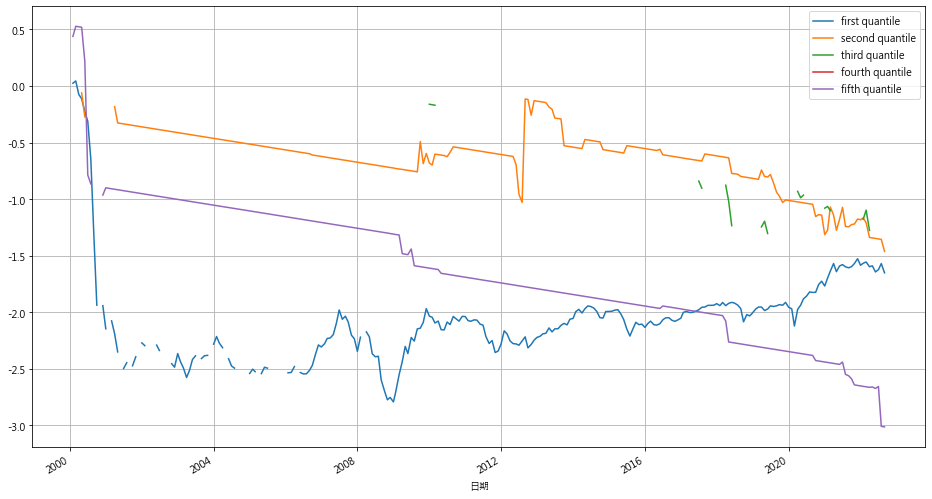

In [332]:
def group_score(df):
    group_names = ['first quantile', 'second quantile', 'third quantile', 'fourth quantile', 'fifth quantile']#, '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
    index = 收盤價.index.intersection(df.index)
    pf = 收盤價.loc[index]
    pf = pf.groupby(pd.Grouper(freq='1m')).tail(1)
    pf = pf.pct_change().shift(-1)
    df_n = df.loc[index]
    df_m = df_n.groupby(pd.Grouper(freq='1m')).tail(1)
    pf = pf.loc[:, pf.columns.intersection(df_m.columns)]
    df_m = df_m.loc[:, pf.columns.intersection(df_m.columns)]
    df_group_results = pd.DataFrame(index=pf.index, columns=group_names)
    for idx, row in df_m.iterrows():
        se = pd.Series(pf.loc[idx, row.index] - 0.00425, name=idx)
        if len(row.dropna()) >= 5:
            df_group_results.loc[idx] = se.groupby(pd.qcut(row.dropna(), 5, labels=group_names)).mean()
    df_group_results.cumsum().plot(figsize=(16, 9), grid=True)
    return df_group_results

group_score(PB.fillna(PB.mean()).dropna(how='all'))

<AxesSubplot:>

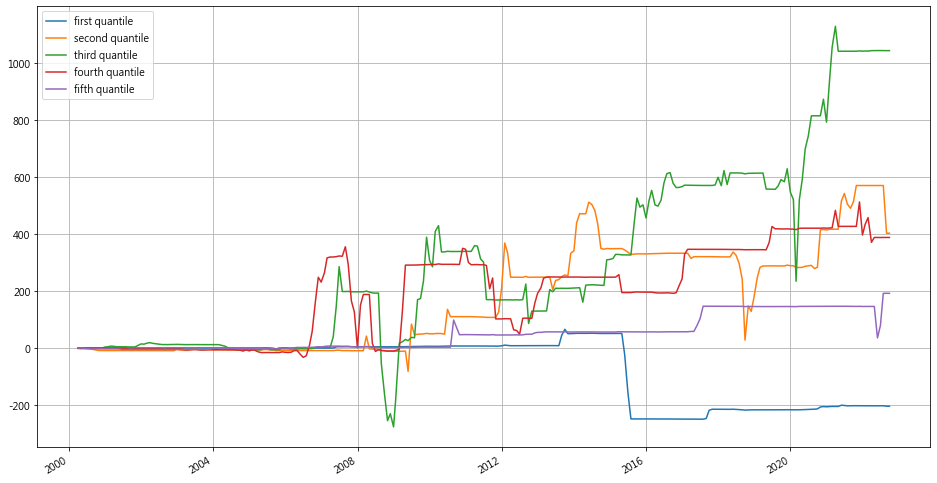

In [309]:
df_group_results.cumsum().plot(figsize=(16, 9), grid=True)

In [276]:
def make_mul_index(df: pd.DataFrame, name: str):
    ndf = df.copy()
    tuples = list(zip([name for _ in ndf], list(ndf.columns)))
    index = pd.MultiIndex.from_tuples(tuples)
    ndf.columns = index
    return ndf

PEm = make_mul_index(PE, 'PE')
殖利率m = make_mul_index(殖利率, '殖利率')

In [280]:
殖利率m.merge(PEm, left_index=True, right_index=True)

殖利率                                                              \
             1101   1102   1103   1104 1107   1108    1109   1110 1113   1201   
2000-01-04 0.5800 1.0200 2.0700 4.1000  NaN 4.9500  5.6200 3.9800  NaN 4.9100   
2000-01-05 0.5600 0.9500 2.0600 4.0400  NaN 4.7600  5.5100 4.0000  NaN 4.6000   
2000-01-06 0.5900 0.9400 1.9800 3.9600  NaN 4.7600  5.3800 3.8800  NaN 4.3000   
2000-01-07 0.5900 0.9400 1.9600 3.9800  NaN 4.7600  5.3600 3.8800  NaN 4.0200   
2000-01-10 0.5700 0.9400 1.9100 3.9800  NaN 4.8300  5.4300 3.9400  NaN 3.7700   
...           ...    ...    ...    ...  ...    ...     ...    ...  ...    ...   
2022-09-22 2.6600 7.7500 3.6400 4.6400  NaN 5.6600  9.1400 1.0900  NaN 2.5200   
2022-09-23 2.7000 8.0300 3.6500 4.6700  NaN 5.6600  9.2200 1.0900  NaN 2.5200   
2022-09-26 2.7900 8.3000 3.7400 4.7500  NaN 5.7100  9.6400 1.1400  NaN 2.5400   
2022-09-27 2.7900 8.3400 3.7400 4.7300  NaN 5.7100  9.7300 1.1200  NaN 2.5200   
2022-09-28 2.8600 8.5200 3.8600 4.8400  NaN 5.8800 10.0200 1.1300  NaN 2.5600   

            ...      PE                                                       \
            ...    3043 4141    5213   6691    4743 1310   5347    4401 6702   
2000-01-04  ...     NaN  NaN     NaN    NaN     NaN  NaN    NaN     NaN  NaN   
2000-01-05  ...     NaN  NaN     NaN    NaN     NaN  NaN    NaN     NaN  NaN   
2000-01-06  ...     NaN  NaN     NaN    NaN     NaN  NaN    NaN     NaN  NaN   
2000-01-07  ...     NaN  NaN     NaN    NaN     NaN  NaN    NaN     NaN  NaN   
2000-01-10  ...     NaN  NaN     NaN    NaN     NaN  NaN    NaN     NaN  NaN   
...         ...     ...  ...     ...    ...     ...  ...    ...     ...  ...   
2022-09-22  ... 19.0000  NaN 11.1000 7.0000 58.8000  NaN 6.9000 11.1000  NaN   
2022-09-23  ... 18.3000  NaN 11.1000 7.0000 60.4000  NaN 6.9000 11.0000  NaN   
2022-09-26  ... 16.9000  NaN 11.0000 6.9000 55.6000  NaN 6.6000 10.7000  NaN   
2022-09-27  ... 17.1000  NaN 11.0000 6.9000 54.9000  NaN 6.6000 10.7000  NaN   
2022-09-28  ... 15.4000  NaN 10.9000 6.7000 51.2000  NaN 6.5000 10.4000  NaN   

                 
           2061  
2000-01-04  NaN  
2000-01-05  NaN  
2000-01-06  NaN  
2000-01-07  NaN  
2000-01-10  NaN  
...         ...  
2022-09-22  NaN  
2022-09-23  NaN  
2022-09-26  NaN  
2022-09-27  NaN  
2022-09-28  NaN  

[5638 rows x 4333 columns]

In [29]:
buy = (PE < 15)&\
    (PB < 1.5)&\
    (成交金額.ge(成交金額.median(axis=1), axis=0))&\
    (收盤價 > MA60)&\
    (收盤價 > MA120)&\
    (EPS_n > 0)&\
    (營業收入淨額_n > 0)&\
    (殖利率 > 4)
buy = buy.shift(1)

In [36]:
buy = (PE.lt(PE.quantile(.32, axis=1), axis=0))&\
    (PB.lt(PB.quantile(.32, axis=1), axis=0))&\
    (成交金額.gt(成交金額.median(axis=1), axis=0))&\
    (收盤價 > MA60)&\
    (收盤價 > MA120)&\
    (EPS_n > 0)&\
    (營業收入淨額_n > 0)&\
    (殖利率.gt(殖利率.quantile(.5, axis=1), axis=0))
buy = buy.shift(1)

In [37]:
sell = (PE.gt(PE.quantile(.32, axis=1), axis=0))&\
    (PB.gt(PB.quantile(.32, axis=1), axis=0))&\
    (成交金額.gt(成交金額.median(axis=1), axis=0))&\
    (收盤價 < MA60)&\
    (收盤價 < MA120)&\
    (EPS_n < 0)&\
    (營業收入淨額_n < 0)&\
    (殖利率.lt(殖利率.quantile(.5, axis=1), axis=0))
sell = sell.shift(1)

In [225]:
# 檢視策略正確性
日期 = '2022-09-01'
股票 = '1444'
print('PE<15: ', PE.at[日期, 股票])
print('PB<1.5: ', PB.at[日期, 股票])
print('成交金額>median: ', 成交金額.at[日期, 股票], ' > ', 成交金額.loc[日期].median())
print('收盤價>60MA, 120MA: ', 收盤價.at[日期, 股票], ' > 60MA: {:.2f}'.format(MA60.at[日期, 股票]), ' 120MA: {:.2f}'.format(MA120.at[日期, 股票]))
print('EPS_n>0: {:.2f}'.format(EPS_n.at[日期, 股票]))
print('營業收入淨額_n>0: {:.2f}'.format(營業收入淨額_n.at[日期, 股票]))
print('殖利率>4 {:.2f}'.format(殖利率.at[日期, 股票]))

PE<15:  11.3
PB<1.5:  1.0
成交金額>median:  24162.0  >  10148.0
收盤價>60MA, 120MA:  11.35  > 60MA: 10.35  120MA: 10.38
EPS_n>0: 0.18
營業收入淨額_n>0: 0.30
殖利率>4 2.64


In [52]:
月初 = buy.groupby(pd.Grouper(freq='m')).head(1)
月初賣 = sell.groupby(pd.Grouper(freq='m')).head(1)
月末 = buy.groupby(pd.Grouper(freq='m')).tail(1)
月末賣 = sell.groupby(pd.Grouper(freq='m')).tail(1)

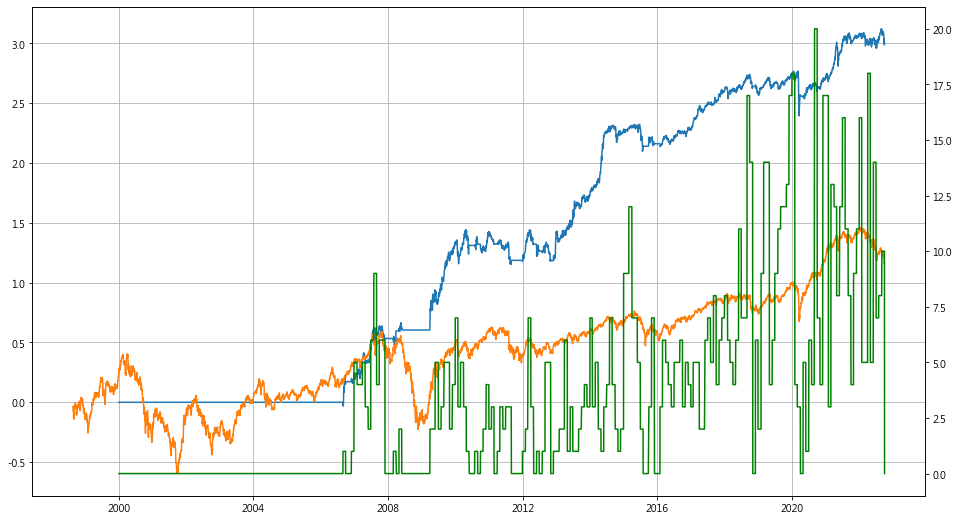

當前持倉:  Index([], dtype='object')
各年平均損益:  日期
2000-12-31    0.0000
2001-12-31    0.0000
2002-12-31    0.0000
2003-12-31    0.0000
2004-12-31    0.0000
2005-12-31    0.0000
2006-12-31    0.2443
2007-12-31    0.2893
2008-12-31    0.0706
2009-12-31    0.7375
2010-12-31    0.0856
2011-12-31   -0.2491
2012-12-31    0.2484
2013-12-31    0.3149
2014-12-31    0.5422
2015-12-31   -0.1215
2016-12-31    0.1161
2017-12-31    0.3295
2018-12-31   -0.0159
2019-12-31    0.1599
2020-12-31   -0.0298
2021-12-31    0.3625
2022-12-31   -0.0775
Freq: A-DEC, dtype: float64


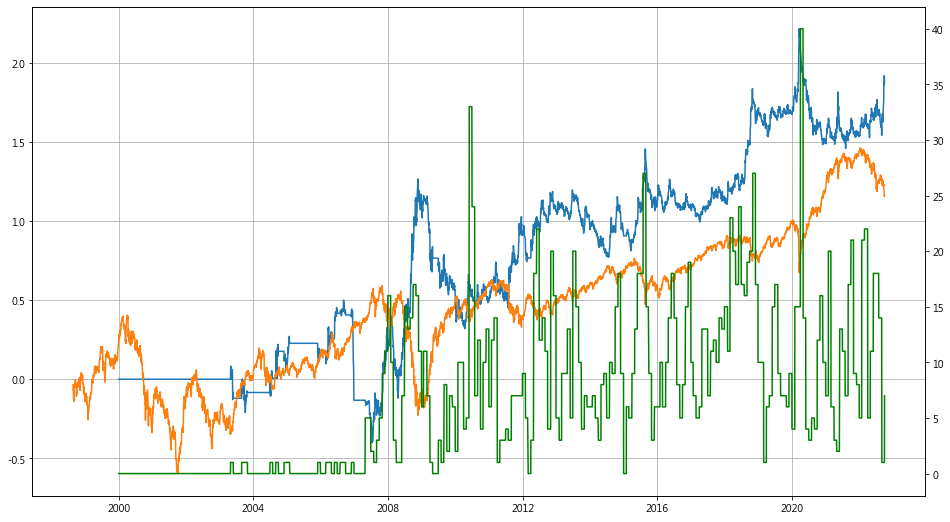

當前持倉:  Index(['3234', '2371', '4142', '2884', '4130', '6538', '6288'], dtype='object')
各年平均損益:  日期
2000-12-31    0.0000
2001-12-31    0.0000
2002-12-31    0.0000
2003-12-31   -0.0838
2004-12-31    0.1815
2005-12-31    0.0660
2006-12-31   -0.2964
2007-12-31    0.3228
2008-12-31    0.8668
2009-12-31   -0.5459
2010-12-31   -0.0049
2011-12-31    0.4253
2012-12-31    0.1366
2013-12-31   -0.1172
2014-12-31   -0.0455
2015-12-31    0.2179
2016-12-31   -0.0429
2017-12-31    0.0433
2018-12-31    0.5798
2019-12-31   -0.0322
2020-12-31   -0.1759
2021-12-31    0.0414
2022-12-31    0.3410
Freq: A-DEC, dtype: float64


In [53]:
def 轉日資料處理(df: pd.DataFrame):
    轉日 = pd.DataFrame(index=收盤價.index, columns=收盤價.columns)
    for i in df.index:
        for c in df.columns:
            轉日.at[i, c] = df.at[i, c]
    轉日 = 轉日.sort_index().fillna(method='ffill')
    return 轉日


def 損益(轉日: pd.DataFrame, 買賣):
    大盤損益 = 大盤收盤價.pct_change().cumsum()
    日損益 = log收盤價.shift(-1) - log收盤價
    換股日損益 = 轉日 * 日損益 * 買賣
    進場 = 轉日 - 轉日.shift(1)
    出場 = 轉日.shift(-1) - 轉日
    費用 = 轉日.copy()
    費用.iloc[:] = 0
    費用[進場 > 0] = 0.001425
    費用[出場 < 0] = 0.004425
    換股日平均損益 = (換股日損益-費用).sum(axis=1) / 轉日.sum(axis=1)
    fig, ax = plt.subplots(figsize=(16, 9))
    ax1 = ax.twinx()
    ax.plot(換股日平均損益.fillna(0).cumsum())
    ax.plot(大盤損益)
    ax1.plot(轉日.sum(axis=1), color='green')
    ax.grid(True)
    plt.show()
    print('當前持倉: ', 轉日.iloc[-1][轉日.iloc[-1]].index)
    print('各年平均損益: ', 換股日平均損益.groupby(pd.Grouper(freq='1y')).sum())
    return 換股日平均損益

def 損益金額(轉日: pd.DataFrame):
    持倉金額 = (轉日 * 收盤價 * 1000).sum(axis=1)
    大盤損益 = (大盤收盤價.pct_change().mul(持倉金額, axis=0)).cumsum()
    日損益 = (收盤價.pct_change().shift(-1))
    換股日損益 = 轉日 * 日損益 * 1000
    換股日平均損益 = 換股日損益.sum(axis=1)
    fig, ax = plt.subplots(figsize=(16, 9))
    ax1 = ax.twinx()
    ax.plot(換股日平均損益.fillna(0).cumsum())
    #ax.plot(大盤損益)
    ax1.plot(轉日.sum(axis=1), color='green')
    ax.grid(True)
    plt.show()
    print('當前持倉: ', 轉日.iloc[-1][轉日.iloc[-1] >= 1].index)


轉日月末 = 轉日資料處理(月末)
轉日月末賣 = 轉日資料處理(月末賣)
日平均 = 損益(轉日月末, 1)
日賣平均 = 損益(轉日月末賣, -1)





In [41]:
月初持倉 = {idx.strftime('%Y-%m'): sorted(row[row].index) for idx, row in 月初.loc['2022', :].iterrows()}

In [63]:
月末.iloc[-1].sum()

0

In [140]:
日平均.loc['2022'].groupby(pd.Grouper(freq='m')).sum()

日期
2022-01-31   -0.0040
2022-02-28    0.0106
2022-03-31   -0.0021
2022-04-30   -0.0175
2022-05-31    0.0086
2022-06-30   -0.0842
2022-07-31    0.0574
2022-08-31    0.0785
2022-09-30   -0.1103
Freq: M, dtype: float64

In [138]:
# 每月持倉嶼進出場
for k, v in 月初持倉.items():
    df = pd.concat([收盤價.shift(-1).loc[k, 月初持倉[k]].head(1).T, 收盤價.shift(-1).loc[k, 月初持倉[k]].dropna().tail(1).T],axis=1)
    df['損益%'] = (df.iloc[:, 1] - df.iloc[:, 0]) / df.iloc[:, 0]
    print(k, df['損益%'].mean())
    df.to_excel(r'C:\Users\ChastLai\Documents\Python Scripts\Output\價值型股票\{}.xlsx'.format(k))

2022-01 -0.013888066731767849
2022-02 0.008746171914915427
2022-03 -0.00855200062772326
2022-04 -0.013726670496822274
2022-05 0.0148737361422093
2022-06 -0.08083597403454794
2022-07 0.07563828509478157
2022-08 0.0896862232687775
2022-09 -0.1020095968068658


In [337]:
轉日 = 轉日資料處理(年初)
# 個別策略
bs = 轉日.copy()
bs_ = 轉日.copy()
# 新增一個全為0的表
bs.iloc[:, :] = 0
bs_.iloc[:, :] = 0
idx1 = bs.index[0]
for idx, row in 收盤價.iterrows():
    # 將會持倉的股票
    bs_.loc[idx] = bs.loc[idx1]
    bs.loc[idx] = bs.loc[idx1]
    可持倉 = 收盤價.loc[idx][轉日.loc[idx]]
    # 錨定價格
    if 可持倉.sum() > 0:
        if (轉日.loc[idx1, 可持倉.index].sum() != 轉日.loc[idx, 可持倉.index].sum()):
            可持倉第一日 = 可持倉
        # 後面的(bs.loc[idx1, 可持倉.index] == 0)是加倉關鍵 改成 <= 3000意思是持倉市值小於三百萬
        buy_in = (收盤價.loc[idx, 可持倉.index] < 可持倉第一日*0.95)&(bs.loc[idx1, 可持倉.index] * 收盤價.loc[idx, 可持倉.index] <= 3000)
        
        if buy_in.sum() > 0 & ((收盤價.loc[idx] * bs_.loc[idx]).sum() < 100000):
            buy_in = buy_in[buy_in]
            bs.loc[idx, buy_in.index] += np.floor(1000 / 收盤價.loc[idx, buy_in.index])
            # 進場後更新可進場價格
            print(idx, 可持倉第一日.sum())
            可持倉第一日.loc[buy_in.index] = 收盤價.loc[idx, buy_in.index]
            print(idx, 可持倉第一日.sum())
    sell_out = (bs_.loc[idx] >= 1) & (轉日.loc[idx] == 0)
    if sell_out.sum() > 0:
        sell_out = sell_out[sell_out]
        bs.loc[idx, sell_out.index] = 0

        # bs.loc[idx, 可持倉.index]\
        #     [(收盤價.loc[idx, 可持倉.index] < 可持倉第一日*0.95)&\
        #     (bs.loc[idx1, 可持倉.index] == 0)] =\
        #     1000 / 收盤價.loc[idx, 可持倉.index] # 一百萬買部位，只買一次
    
    idx1 = idx

2007-01-03 00:00:00 167.78000000000003
2007-01-03 00:00:00 167.26000000000002
2007-01-04 00:00:00 167.26000000000002
2007-01-04 00:00:00 166.38000000000002
2007-01-05 00:00:00 166.38000000000002
2007-01-05 00:00:00 164.63000000000005
2007-01-08 00:00:00 164.63000000000005
2007-01-08 00:00:00 164.09000000000003
2007-01-10 00:00:00 164.09000000000003
2007-01-10 00:00:00 163.03
2007-01-11 00:00:00 163.03
2007-01-11 00:00:00 160.6
2007-01-29 00:00:00 160.6
2007-01-29 00:00:00 159.62
2007-02-01 00:00:00 159.62
2007-02-01 00:00:00 158.6
2007-03-01 00:00:00 158.6
2007-03-01 00:00:00 158.41
2007-03-03 00:00:00 158.41
2007-03-03 00:00:00 158.20999999999998
2007-03-05 00:00:00 158.20999999999998
2007-03-05 00:00:00 156.27999999999997
2007-03-14 00:00:00 156.27999999999997
2007-03-14 00:00:00 155.82
2007-05-11 00:00:00 155.82
2007-05-11 00:00:00 155.66
2007-11-27 00:00:00 155.66
2007-11-27 00:00:00 155.47
2007-12-17 00:00:00 155.47
2007-12-17 00:00:00 155.15
2007-12-18 00:00:00 155.15
2007-12-18 

In [336]:
bs.loc[idx1, 可持倉.index] * 收盤價.loc[idx, 可持倉.index]# <= 3000

3323   3,558.5000
3015   2,936.7000
5469   3,140.5000
2353   3,532.0500
2393   3,155.6000
6270   2,052.0000
2324       0.0000
3036   7,825.6000
3028   1,860.2000
4935   4,142.6000
1604   1,014.0000
6005   3,191.6000
4958   2,173.5000
Name: 2022-09-28 00:00:00, dtype: object

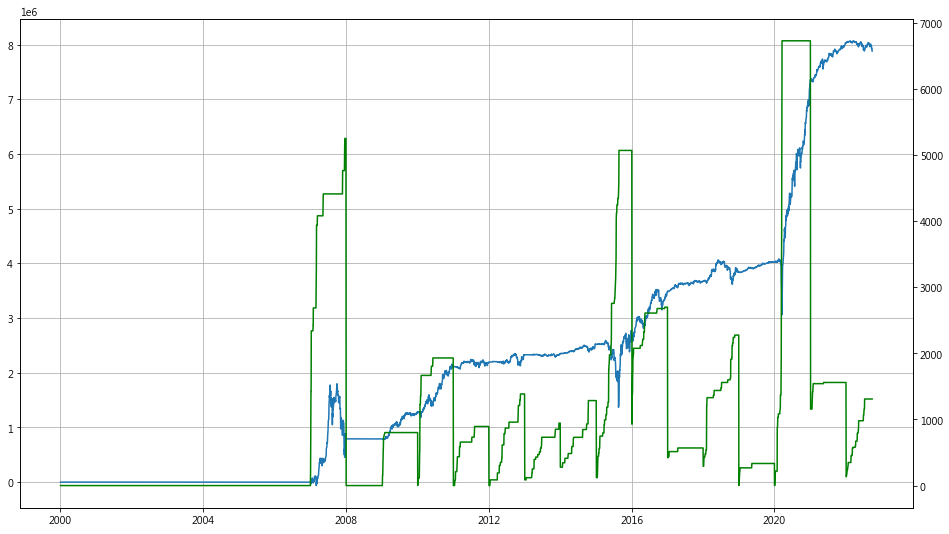

當前持倉:  Index(['3323', '3015', '5469', '2353', '2393', '6270', '3036', '3028', '4935',
       '1604', '6005', '4958'],
      dtype='object')


In [331]:
損益金額(bs_)

<AxesSubplot:xlabel='日期'>

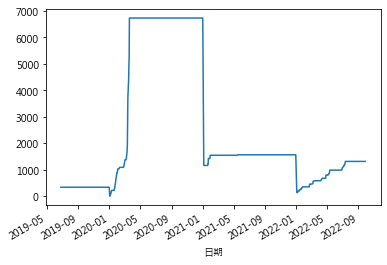

In [329]:
bs.sum(axis=1)[-800:].plot()

In [ ]:
月初轉日 = pd.DataFrame(index=收盤價.index, columns=收盤價.columns)
for i in 月初.index:
    for c in 月初.columns:
        月初轉日.at[i, c] = 月初.at[i, c]

月初轉日.fillna(method='ffill', inplace=True)

In [ ]:
季初轉日 = pd.DataFrame(index=收盤價.index, columns=收盤價.columns)
for i in 季初.index:
    for c in 季初.columns:
        季初轉日.at[i, c] = 季初.at[i, c]

季初轉日.fillna(method='ffill', inplace=True)

In [ ]:
大盤損益 = 大盤收盤價.pct_change().cumsum()
日損益 = (收盤價.pct_change().shift(-1))
月初換股日損益 = 月初轉日 * 日損益
月初換股日平均損益 = 月初換股日損益.sum(axis=1) / 月初轉日.sum(axis=1)
fig, ax = plt.subplots(figsize=(16, 9))
ax1 = ax.twinx()
ax.plot(月初換股日平均損益.fillna(0).cumsum())
ax.plot(大盤損益)
ax1.plot(月初轉日.sum(axis=1), color='green')
ax.grid(True)
plt.show()

In [ ]:
大盤損益 = 大盤收盤價.pct_change().cumsum()
日損益 = (收盤價.pct_change().shift(-1))
季初換股日損益 = 季初轉日 * 日損益
季初換股日平均損益 = 季初換股日損益.sum(axis=1) / 季初轉日.sum(axis=1)
fig, ax = plt.subplots(figsize=(16, 9))
ax1 = ax.twinx()
ax.plot(季初換股日平均損益.fillna(0).cumsum())
ax.plot(大盤損益)
ax1.plot(季初轉日.sum(axis=1), color='green')
ax.grid(True)
plt.show()

In [ ]:
月初轉日.loc['2022-09-01'][月初轉日.loc['2022-09-01']].index

In [ ]:
月初換股損益 = 月初 * 一個月損益.loc[月初.index]
月初換股損益.sum(axis=1).cumsum().plot(figsize=(16, 9))

In [ ]:
月初換股日平均損益 = 月初換股日損益.sum(axis=1) / 月初轉日.sum(axis=1)
月初換股日平均損益.fillna(0).cumsum().plot(figsize=(16, 9))

In [ ]:
月初換股日平均損益.groupby(pd.Grouper(freq='1y')).sum()